In [9]:
import torch
import numpy as np

In [10]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform = transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, sampler = train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, sampler = valid_sampler, num_workers= num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers= num_workers)

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img =img/2 + 0.5
  plt.imshow(np.transpose(img,(1,2,0)))

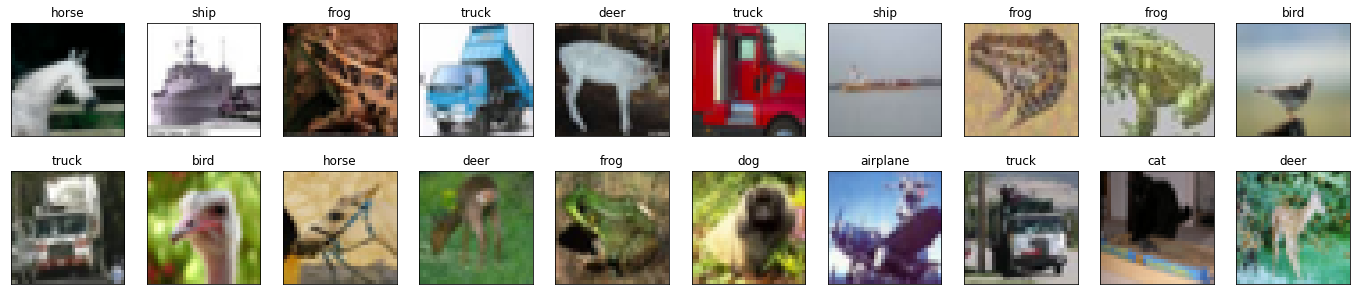

In [12]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(24,5))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

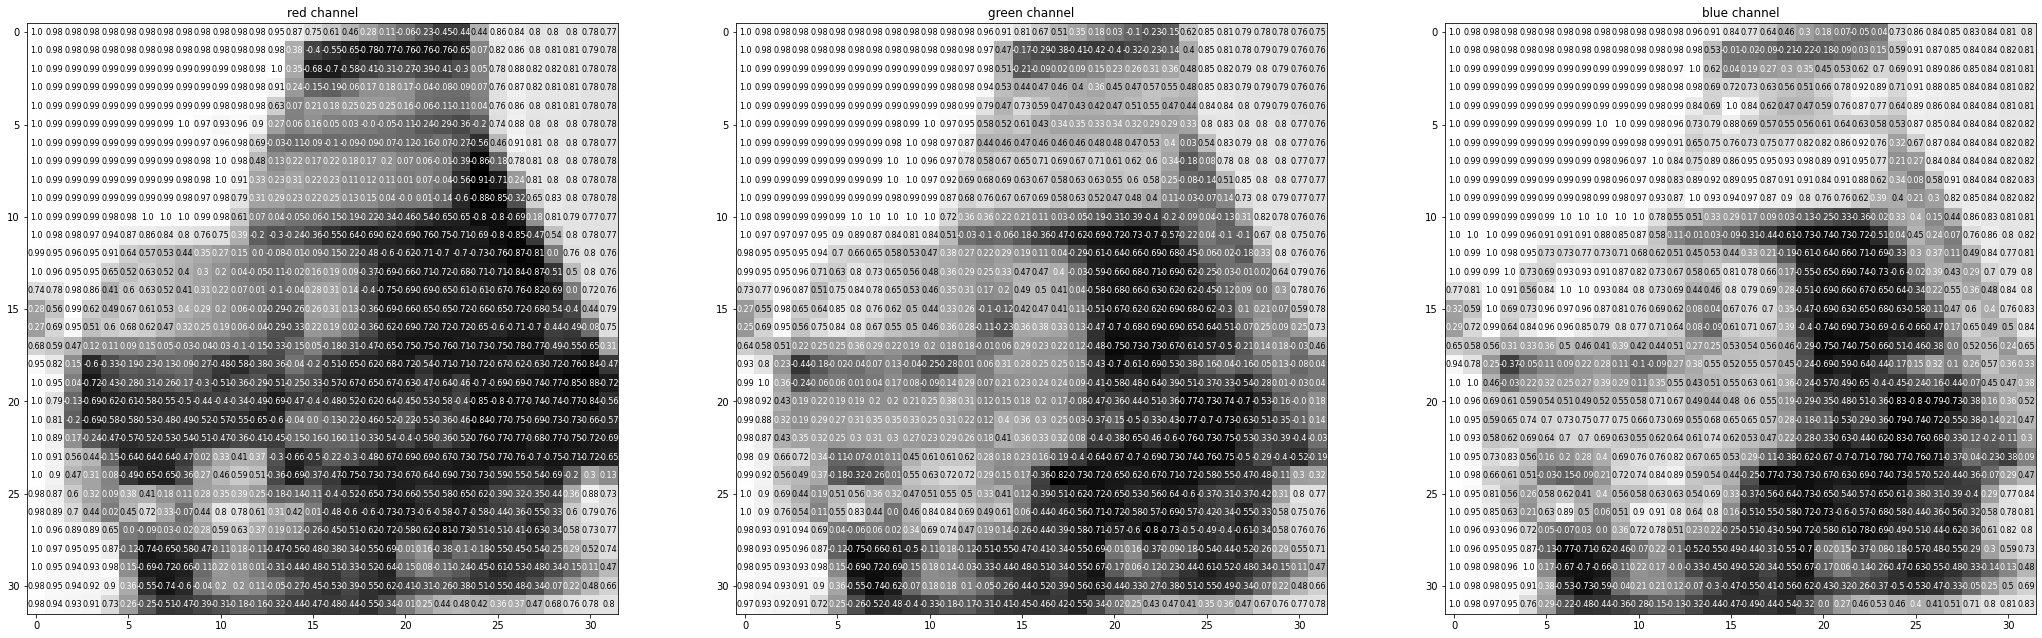

In [13]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): 
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding =1)
    self.conv3 = nn.Conv2d(32,64,3, padding =1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*4*4, 500)
    self.fc2 =nn.Linear(500,10)
    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x= x.view(-1,64*4*4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = Net()
print(model)
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [19]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr =0.01)

### Train the network

In [22]:
n_epochs = 30
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
       
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.135140 	Validation Loss: 1.853941
Validation loss decreased (inf --> 1.853941).  Saving model ...
Epoch: 2 	Training Loss: 1.690645 	Validation Loss: 1.510223
Validation loss decreased (1.853941 --> 1.510223).  Saving model ...
Epoch: 3 	Training Loss: 1.491096 	Validation Loss: 1.394552
Validation loss decreased (1.510223 --> 1.394552).  Saving model ...
Epoch: 4 	Training Loss: 1.378617 	Validation Loss: 1.289933
Validation loss decreased (1.394552 --> 1.289933).  Saving model ...
Epoch: 5 	Training Loss: 1.287858 	Validation Loss: 1.209079
Validation loss decreased (1.289933 --> 1.209079).  Saving model ...
Epoch: 6 	Training Loss: 1.205571 	Validation Loss: 1.147098
Validation loss decreased (1.209079 --> 1.147098).  Saving model ...
Epoch: 7 	Training Loss: 1.137092 	Validation Loss: 1.074449
Validation loss decreased (1.147098 --> 1.074449).  Saving model ...
Epoch: 8 	Training Loss: 1.070944 	Validation Loss: 1.044158
Validation loss decreased (1.07444

In [23]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Test the Trained Network

In [24]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
  if train_on_gpu:
    data,target = data.cuda(), target.cuda()
  output = model(data)
  loss =criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output,1) #returns maximum number in each row
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))





Test Loss: 0.736874

Test Accuracy of airplane: 77% (774/1000)
Test Accuracy of automobile: 87% (876/1000)
Test Accuracy of  bird: 67% (670/1000)
Test Accuracy of   cat: 53% (539/1000)
Test Accuracy of  deer: 68% (687/1000)
Test Accuracy of   dog: 66% (661/1000)
Test Accuracy of  frog: 81% (815/1000)
Test Accuracy of horse: 77% (778/1000)
Test Accuracy of  ship: 89% (891/1000)
Test Accuracy of truck: 80% (806/1000)

Test Accuracy (Overall): 74% (7497/10000)


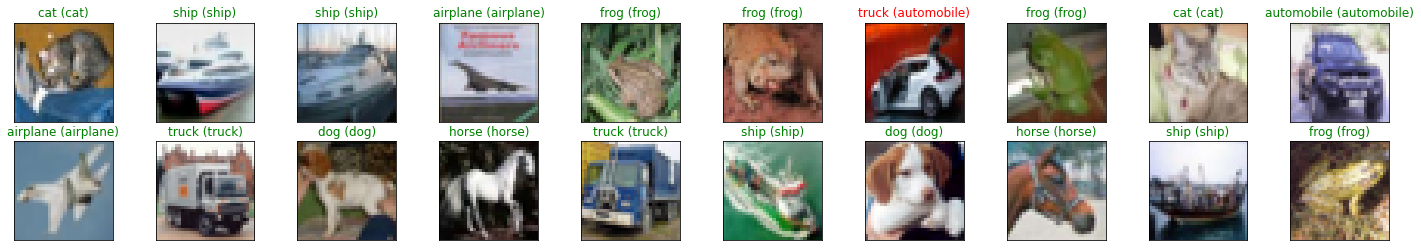

In [25]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))